In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import random
from collections import defaultdict
import numpy as np
import pandas as pd
import crocoddyl
crocoddyl.switchToNumpyArray()

In [50]:
def point(h, k, r):
    theta = random.random() * 2 * np.pi
    return h + np.cos(theta) * r, k + np.sin(theta) * r




In [51]:
def run_croc(initial_config):
    
    
    model = crocoddyl.ActionModelUnicycle()
    model.costWeights = np.matrix([1, 0.3]).T
    problem = crocoddyl.ShootingProblem(np.matrix(initial_config).T, [ model ] * 30, model)
    ddp = crocoddyl.SolverFDDP(problem)
    ddp.solve([], [], 1000)
    return ddp

In [52]:
data = []
cost_dict = defaultdict()
for _ in range(100000):
    initial_config = [random.uniform(-1.99, 1.99), random.uniform(-1.99, 1.99), 0]
    ddp = run_croc(initial_config)
    if ddp.iter < 1000:
        
        position = []
        # Attach x, y, theta
        position.extend(i for i in ddp.xs[0])
        # Attach linear_velocity, angular_velocty
        position.extend(i for i in ddp.us[0])
        # Attach cost
        position.append(sum(d.cost for d in ddp.datas()))
        # Attach the number of iterations
        position.append(ddp.iter)
        data.append(position)
        
        # Store the key = cost and value = trajectory(ie x, y) in dictionary 
        a = np.delete(np.array(ddp.xs), 2, 1)
        cost_dict[sum(d.cost for d in ddp.datas())] = a

data = np.array(data)
df = pd.DataFrame(data[0:,0:], columns = ["x_position", "y_position", "z_position", "linear_velocity", "angular_velocity", "value_function", "iterations"])
df = df.sample(frac=1).reset_index(drop=True)


In [53]:
# Plot linear velocity aka control 0

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 80

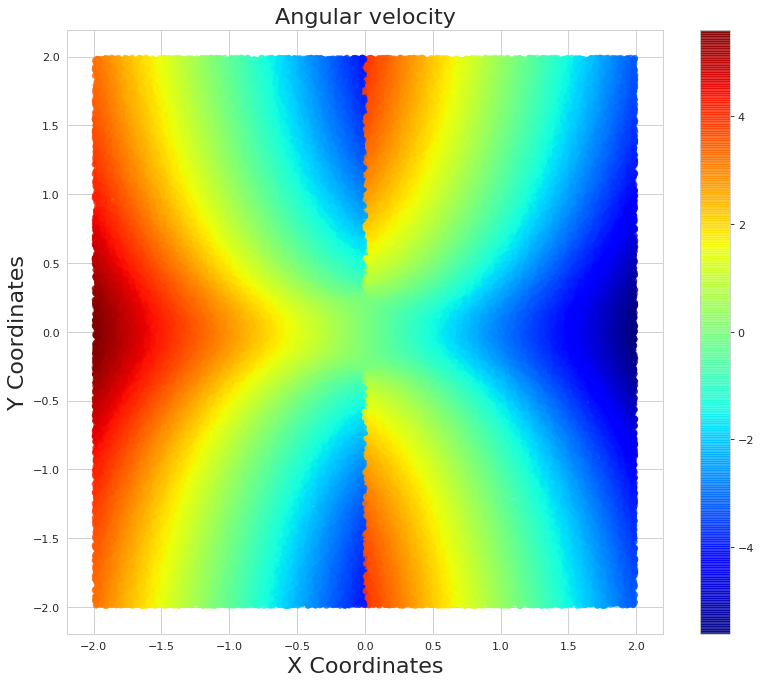

In [54]:
fig = plt.figure(figsize=(12, 10))
plt.axis(aspect='image')

plt.scatter(data[:, 0], data[:, 1], c=data[:, 3], cmap = 'jet', alpha = 0.8, linewidths = 0)
plt.xlabel("X Coordinates", fontsize = 20)
plt.ylabel("Y Coordinates", fontsize = 20)
cb = plt.colorbar()
#cb.set_label("Value Function", fontsize = 20)
plt.title("Angular velocity", fontsize = 20)
plt.show()

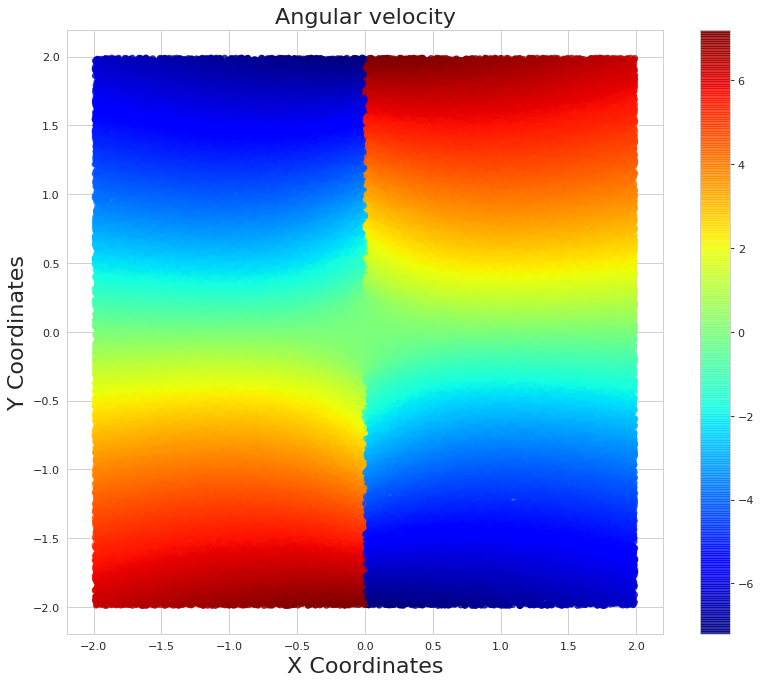

In [55]:
# Plot angular velocity aka control 1 


fig = plt.figure(figsize=(12, 10))
plt.axis(aspect='image')

plt.scatter(data[:, 0], data[:, 1], c=data[:, 4], cmap = 'jet', alpha = 0.8, linewidths = 0)
plt.xlabel("X Coordinates", fontsize = 20)
plt.ylabel("Y Coordinates", fontsize = 20)
cb = plt.colorbar()
#cb.set_label("Value Function", fontsize = 20)
plt.title("Angular velocity", fontsize = 20)
plt.show()

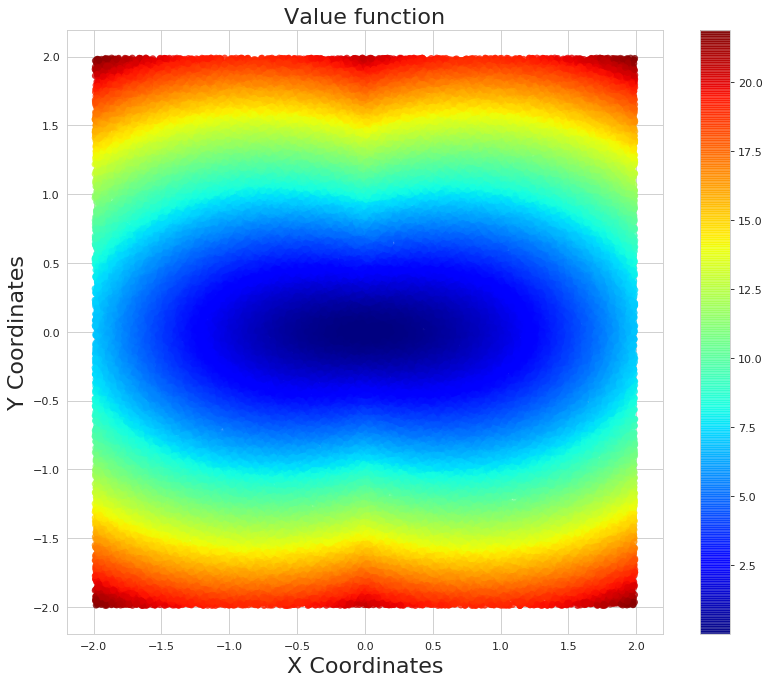

In [56]:
# Plot value function


fig = plt.figure(figsize=(12, 10))
plt.axis(aspect='image')

plt.scatter(data[:, 0], data[:, 1], c=data[:, 5], cmap = 'jet', alpha = 0.8, linewidths = 0)
plt.xlabel("X Coordinates", fontsize = 20)
plt.ylabel("Y Coordinates", fontsize = 20)
cb = plt.colorbar()
#cb.set_label("Value Function", fontsize = 20)
plt.title("Value function", fontsize = 20)
plt.show()

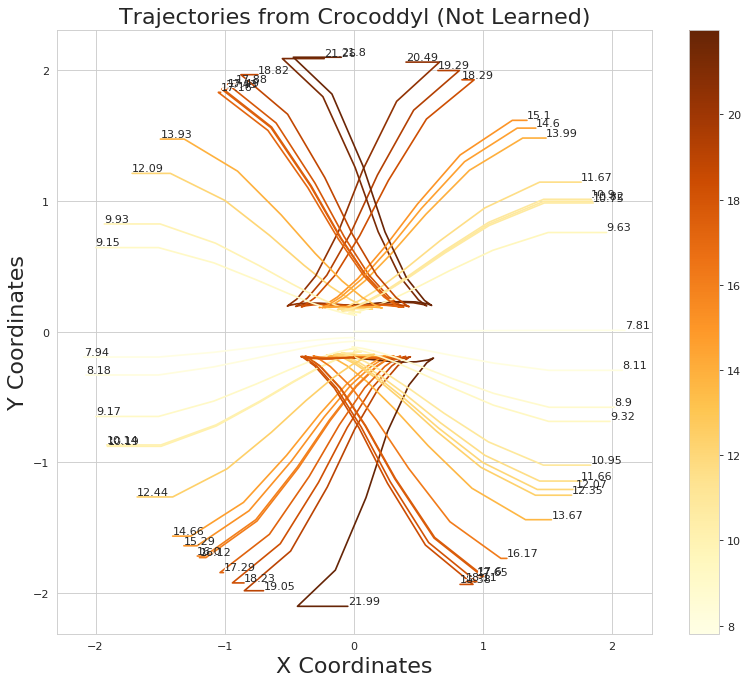

In [57]:
# Plot trajectories
cost_trajectory = defaultdict()

for _ in range(50):
    x, y = point(0, 0, 2.1)
    
    initial_config = [x, y, 0]
    
    ddp = run_croc(initial_config)
    if ddp.iter < 1000:
        # Store the key = cost and value = trajectory(ie x, y) in dictionary 
        a = np.delete(np.array(ddp.xs), 2, 1)
        cost_trajectory[sum(d.cost for d in ddp.datas())] = a
        
c = cost_trajectory.keys()
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))
cmap = mpl.cm.ScalarMappable(norm = norm, cmap=mpl.cm.YlOrBr)
cmap.set_array([])

fig = plt.figure(figsize=(12, 10))
    
for key, trajectory in cost_trajectory.items():
    plt.scatter(trajectory[:, 0], trajectory[:, 1], marker = '', zorder=2, s=50,linewidths=0.2,alpha=.8, cmap = cmap )
    plt.plot(trajectory[:, 0], trajectory[:, 1], c=cmap.to_rgba(key))
    label = np.around(key, 2)
    plt.annotate(label, xy = (trajectory[0,0], trajectory[0,1]),
                    arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"),
                    horizontalalignment='left',
                    verticalalignment='bottom',)
    
plt.xlabel("X Coordinates", fontsize = 20)
plt.ylabel("Y Coordinates", fontsize = 20)
plt.title("Trajectories from Crocoddyl (Not Learned)", fontsize =20)

plt.colorbar(cmap)

In [58]:
df.head(1)

,x_position,y_position,z_position,linear_velocity,angular_velocity,value_function,iterations
0,-1.681972,-1.749355,0.0,2.293836,5.957306,17.694946,24.0


In [59]:
df.shape

(100000, 7)

In [60]:
x_train = data[0:90000,0:2]
y_train = data[0:90000, 2:]

x_test = data[90000:,0:2]
y_test = data[90000:, 2:]

print(x_train.shape, y_train.shape)

(90000, 2) (90000, 5)


In [61]:
print(x_test.shape, y_test.shape)

(10000, 2) (10000, 5)


In [62]:
import keras
from keras import regularizers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout


In [63]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model = keras.models.Sequential()
model.add(Dense(256, input_dim=(x_train.shape[1])))
model.add(Activation('relu'))
for _ in range(5):
    model.add(Dense(256,
                    activation = "relu",
                    kernel_initializer='random_uniform',
                    kernel_regularizer=regularizers.l2(0.01),
                    activity_regularizer=regularizers.l1(0.01)))            
    model.add(Dropout(0.25))

model.add(Dense(y_train.shape[1], 
                activation = 'tanh'))        


rms = optimizers.RMSprop(lr = 0.001, rho=0.9)

model.compile(loss=root_mean_squared_error,
              optimizer=rms,
              metrics=['mean_squared_error', 'logcosh', root_mean_squared_error])    

In [ ]:
print(f'Training neural net on {x_train.shape[0]} trajectories')
        
model.fit(x_train, 
          y_train,
          epochs = 200,
          batch_size= 16,
          verbose = 1
          )

Training neural net on 90000 trajectories
Epoch 1/200
90000/90000 [==============================] - 22s 246us/step - loss: 17.3833 - mean_squared_error: 308.0549 - logcosh: 8.6457 - root_mean_squared_error: 17.3758
Epoch 2/200
90000/90000 [==============================] - 21s 230us/step - loss: 17.3202 - mean_squared_error: 306.0617 - logcosh: 8.5979 - root_mean_squared_error: 17.3194
Epoch 3/200
90000/90000 [==============================] - 19s 208us/step - loss: 17.3145 - mean_squared_error: 306.0615 - logcosh: 8.5979 - root_mean_squared_error: 17.3137
Epoch 4/200
90000/90000 [==============================] - 19s 209us/step - loss: 17.3179 - mean_squared_error: 306.0611 - logcosh: 8.5979 - root_mean_squared_error: 17.3172
Epoch 5/200
90000/90000 [==============================] - 22s 239us/step - loss: 17.3225 - mean_squared_error: 306.0613 - logcosh: 8.5979 - root_mean_squared_error: 17.3217
Epoch 6/200
90000/90000 [==============================] - 22s 245us/step - loss: 17.320

In [ ]:
# Evaluate the model
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=16)
print('test loss, test acc:', results)

# Generate predictions on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test[:25])
print('predictions shape:', predictions.shape)

In [ ]:
predictions